# 주제 : 추천 시스템 - 영화 데이터셋과 Embedding & Ranking 알고리즘으로 추천시스템 만들기
----------

## 실습 가이드
    1. 데이터를 다운로드하여 Colab에 불러옵니다.
    2. 필요한 라이브러리는 모두 코드로 작성되어 있습니다.
    3. 코드는 위에서부터 아래로 순서대로 실행합니다.
    4. 전체 문제 구성은 좌측 첫 번째 아이콘을 통해 확인할 수 있습니다.
    
    
## 데이터 소개
    - 이번 주제도 마찬가지로 MovieLens Dataset을 사용합니다.
    - 같은 데이터라도 상황과 데이터의 크기에 따라 다양한 추천 방법을 활용할 수 있어야 합니다.
    - 파일은 세 개 이며, 각각의 컬럼은 아래와 같습니다.
    
    1. ratings.dat
    user_id : 영화를 시청한 사용자 아이디
    movie_id : 영화의 아이디
    rating : 사용자가 영화를 평가한 점수
    time : 사용자가 영화를 시청한 시간
    
    2. movies.dat
    movie_id : 영화의 아이디
    title : 영화 제목
    genre : 영화 장르

    3. users.dat
    user_id : 사용자 아이디
    gender : 사용자 성별
    age : 사용자 나이
    occupation : 사용자 직업코드
    zipcode : 사용자 거주코드

    
- 데이터 출처: https://grouplens.org/datasets/movielens/


## 최종 목표
    - Large-Scale 에서 적용 가능한 추천시스템 구조 이해
    - Word2Vec 기반의 임베딩 모델 이해
    - EDA로 수행할 수 있는 다양한 인사이트 활용
    - Point-wise 모델링에 대한 이해
    - Factorization Machine 알고리즘에 대한 이해
    - ML에 활용할 수 있는 데이터 변환 능력 습득
    - 모델의 추천 결과를 평가하는 방법에 대한 연습

- 출제자 : 윤기태 강사
---

## Step 1. Word2Vec 알고리즘 기반 추천 후보군 생성

#### Rating Matrix 기반 추천시스템의 한계

    [Memory Based Recommendations]
    1. 만약 유저, 영화의 수가 3000이 아니라 3천만 개 라면?
    2. Matrix의 크기는 30,000,000 X 30,000,000
    3. 연산량 자체도 문제가 되지만, Extreme Sparse 벡터가 되면서 정확도 역시 현저하게 떨어지게 됨
    4. 차원축소, ALS 등의 방법으로 어느정도 극복할 수 있지만, 근본적인 해결책이 되지는 못함

- Recommendation in Large Scale System
  - Architecture
  ![recsys_architecture](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2F30pCp%2Fbtqv7PV6365%2FCkl5dwvSoQF3RdneCIzGr1%2Fimg.png)
  - 데이터 수집과 처리 단계를 제외하면, 추천시스템은 다음과 같은 레이어로 구분되는 추세
    - `Generate Candidates` : 수백, 수천만개의 Item 중, 후보가 될 만한 Item을 추출. 여기에 CF 등의 방법을 사용할 수도 있지만, 일반적으로는 연산량이 작은 여러 개의 전략(시나리오)들을 합쳐서 coverage 자체를 확보하는 역할을 함. 예를 들면 인기도가 높은 Item, 연관성이 높은 Item 등을 별개의 전략으로 추출하는 것.
    - `Intention Predict` : User의 Context에 기반하여 Candidates를 한 번 더 좁혀주는 역할. 반드시 필요한 단계는 아니며, Candidates를 추렸음에도 여전히 Large Scale 문제를 가지고 있는 경우에 필터링의 역할로 사용할 수 있음.
    - `Personalized Ranking` : 일반적으로 추천시스템에서 추천이 잘 되었는지를 평가하는 지표는 CTR, CVR 같은 지표. 이 지표들을 Maximize 할 수 있는 방법으로 개인화 모델을 학습. 일반적인 Classifier를 생각해도 무방하며, 학습 데이터셋을 잘 구축하는 것이 좋은 추천 랭킹모델을 만드는 것.

![recsys_architecture2](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FUsbKo%2Fbtqv7PBN46z%2Fd4m5pf7lrKs1CqxzkROY81%2Fimg.png)


-----

#### Word2Vec 기반의 Movie2Vec 만들기

    [Word2Vec]
    1. 임베딩(Embedding) 방법론 중 가장 대중적이고 성능이 좋은 방법
    2. 같은 문장 내, 혹은 비슷한 위치에 등장하는 단어들은 유사한 의미를 가지고 있을 것이라는 가정.
    3. 원래는 단어를 벡터로 표현하는 방법으로 고안되었지만, word2vec의 메커니즘을 다양하게 활용할 수 있음
    4. Word2Vec은 중심 단어와 주변 단어와의 연관성을 학습하여 벡터로 표현함.
      - 예시 문장 : "역시 성공은 고난을 동반 말없이 등산을 등반하는 것처럼"
      - 만약 "성공"이라는 단어를 중심 단어로 활용한다면, [역시, _, 고난을, 동반] 이러한 주변 단어를 가지고 중심에 있는 단어의 벡터를 학습할 수 있게 됨. (Skip-gram 방식. CBOW는 반대)

![skipgram](http://i.imgur.com/TupGxMl.png)

    [학습 원리]
    1. 단어셋의 크기를 dim으로 하는 input/output 벡터를 활용하여 softmax classification
    2. 따라서 아래 함수를 최소화 하는 것을 목표로 하는 network를 학습하게 됨

![function](https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/images/function.png)

    [벡터 표현]
    1. 학습된 네트워크의 hidden layer (projection layer)에 단어의 벡터가 표현됨
    2. 이를 lookup 이라고 함

![lookup](https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/images/lookup.png)

-----

    [영화의 벡터 표현]
    1. word2vec 방법에서 word를 item으로 치환하면, item2vec으로 활용할 수 있음 (많은 추천시스템에서 활용하는 방법)
    2. 단, 이 방법은 데이터의 meta-data가 하나의 축으로 이루어진 단어에서와 달리, 영화처럼 multi-axis meta-data를 가진 데이터에서는 완전한 표현이라고 볼 수 없음 (ex. 장르, 감독 등등의 정보)
    3. 또한 item2vec 메커니즘을 추천시스템에 활용하면 필연적으로 cold-start 문제가 발생할 수 있음
    4. `Cold-start Problem` : 새로운 유저나 새로운 아이템을 대상으로 추천하게 될 때, 기존 학습모델에서는 등장한 적 없는 데이터이기 때문에 추천 대상으로 포함되기 어려운 현상
    5. 임베딩 기반 추천에서 cold-start를 극복하는 방법은 여러가지가 있지만, 그 중에서 가장 적용하기 간단하면서도 중요한 개념을 담고 있는 meta-prod2vec을 활용
    6. 자세한 내용 : https://arxiv.org/pdf/1607.07326.pdf

![meta-prod2vec](https://image.slidesharecdn.com/metaprod2vec-161007133531/95/metaprod2vec-simple-product-embeddings-with-sideinformation-36-638.jpg?cb=1475847427)

### 문제 1. 데이터 불러오기

In [1]:
import pandas as pd

rating_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/ratings.dat'
rating_df = pd.io.parsers.read_csv(rating_url, names=['user_id', 'movie_id', 'rating', 'time'], delimiter='::', engine ='python')

movie_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/movies.dat'
movie_df = pd.io.parsers.read_csv(movie_url, names=['movie_id', 'title', 'genre'], delimiter='::', engine ='python', encoding='ISO-8859-1')

user_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/users.dat'
user_df = pd.io.parsers.read_csv(user_url, names=['user_id', 'gender', 'age', 'occupation', 'zipcode'], delimiter='::', engine ='python')

### 문제 2. EDA & 전처리 - 사용자별 시청 목록 추출

In [2]:
# groupby, apply 함수로 사용자별 시청 목록 추출
def get_recent_movie_list_sort_by_time(x):
  return x.sort_values(['time'])['movie_id'].tolist() #시청 시간별로 사용자별 시청목록 추출

user_watch_list = rating_df.groupby('user_id')[['movie_id','time']].apply(lambda x: get_recent_movie_list_sort_by_time(x))

In [3]:
user_watch_list

user_id
1       [3186, 1721, 1022, 1270, 2340, 1836, 3408, 120...
2       [1198, 1217, 1210, 2717, 1293, 2943, 1225, 119...
3       [593, 2858, 3534, 1968, 1961, 1431, 1266, 1378...
4       [1210, 1097, 3468, 3527, 480, 260, 1196, 1198,...
5       [2717, 919, 908, 356, 1250, 2188, 2858, 1127, ...
                              ...                        
6036    [1721, 2376, 3438, 2428, 1883, 2492, 2827, 268...
6037    [1882, 2028, 1267, 702, 3508, 562, 3148, 858, ...
6038    [920, 3396, 1210, 2146, 356, 1387, 1079, 1148,...
6039    [111, 282, 2067, 930, 1230, 3133, 3022, 947, 3...
6040    [858, 2384, 593, 1961, 2019, 573, 3111, 3505, ...
Length: 6040, dtype: object

In [4]:
rating_df['movie_id'].value_counts()

2858    3428
260     2991
1196    2990
1210    2883
480     2672
        ... 
3323       1
624        1
763        1
2484       1
133        1
Name: movie_id, Length: 3706, dtype: int64

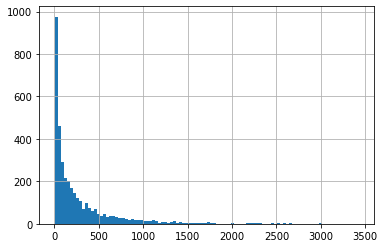

In [5]:
rating_df['movie_id'].value_counts().hist(bins = 100)

### 문제 3. EDA & 전처리 - 영화 개봉년도 피쳐 생성

In [6]:
movie_df.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
# title 피처에서 개봉 년도 (ex. 1990, 2000...) 분리
movie_df['decade'] = movie_df['title'].apply(lambda x : x[-5:-2] + '0')

In [8]:
movie_df.head()

,movie_id,title,genre,decade
0,1,Toy Story (1995),Animation|Children's|Comedy,1990
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1990
2,3,Grumpier Old Men (1995),Comedy|Romance,1990
3,4,Waiting to Exhale (1995),Comedy|Drama,1990
4,5,Father of the Bride Part II (1995),Comedy,1990


In [9]:
import seaborn as sns

# sns.barplot으로 개봉 년도별 영화 갯수 시각화
released_year_area = movie_df['decade'].value_counts().sort_index()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


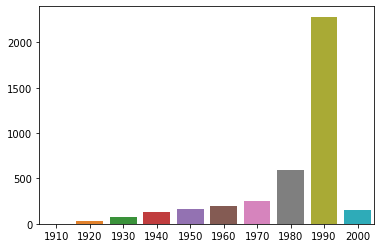

In [10]:
sns.barplot(released_year_area.index, released_year_area.values)

### 문제 4. EDA & 전처리 - 영화 장르 피쳐 생성

In [11]:
movie_df['genre'].value_counts()

Drama                                  843
Comedy                                 521
Horror                                 178
Comedy|Drama                           162
Comedy|Romance                         142
                                      ... 
Action|Adventure|Animation               1
Action|Adventure|Crime|Drama             1
Adventure|Musical                        1
Action|Crime|Mystery                     1
Action|Comedy|Crime|Horror|Thriller      1
Name: genre, Length: 301, dtype: int64

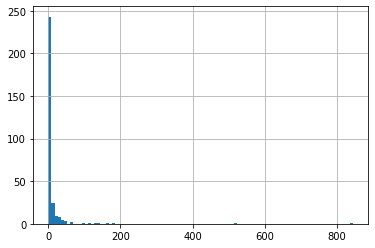

In [12]:
movie_df['genre'].value_counts().hist(bins = 100)

In [13]:
# genre 피처에서 영화의 대표 장르 추출
movie_df['main_genre'] = movie_df['genre'].apply(lambda x: x.split('|')[0])

In [14]:
movie_df

,movie_id,title,genre,decade,main_genre
0,1,Toy Story (1995),Animation|Children's|Comedy,1990,Animation
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1990,Adventure
2,3,Grumpier Old Men (1995),Comedy|Romance,1990,Comedy
3,4,Waiting to Exhale (1995),Comedy|Drama,1990,Comedy
4,5,Father of the Bride Part II (1995),Comedy,1990,Comedy
...,...,...,...,...,...
3878,3948,Meet the Parents (2000),Comedy,2000,Comedy
3879,3949,Requiem for a Dream (2000),Drama,2000,Drama
3880,3950,Tigerland (2000),Drama,2000,Drama
3881,3951,Two Family House (2000),Drama,2000,Drama


In [15]:
movie_df['main_genre'].value_counts()

Drama          1176
Comedy         1024
Action          503
Horror          262
Adventure       155
Crime           131
Documentary     123
Thriller        101
Animation        90
Children's       89
Romance          50
Sci-Fi           46
Mystery          36
Western          33
Musical          25
Film-Noir        25
War              12
Fantasy           2
Name: main_genre, dtype: int64

### 문제 5. Embedding - EDA 결과를 활용하여 Movie2Vec 학습

In [16]:
movie_df.head()

,movie_id,title,genre,decade,main_genre
0,1,Toy Story (1995),Animation|Children's|Comedy,1990,Animation
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1990,Adventure
2,3,Grumpier Old Men (1995),Comedy|Romance,1990,Comedy
3,4,Waiting to Exhale (1995),Comedy|Drama,1990,Comedy
4,5,Father of the Bride Part II (1995),Comedy,1990,Comedy


In [17]:
movie_meta_dict = movie_df.set_index('movie_id')[['decade', 'main_genre']].to_dict()

# ex.
# {'main_genre': {1: 'Animation',
#   2: 'Adventure',
#   3: 'Comedy',
#   4: 'Comedy',
#   5: 'Comedy',
#   ...
#   'released_year_area': {...},
#   ...
# }

In [18]:
movie_meta_dict

{'decade': {1: '1990',
  2: '1990',
  3: '1990',
  4: '1990',
  5: '1990',
  6: '1990',
  7: '1990',
  8: '1990',
  9: '1990',
  10: '1990',
  11: '1990',
  12: '1990',
  13: '1990',
  14: '1990',
  15: '1990',
  16: '1990',
  17: '1990',
  18: '1990',
  19: '1990',
  20: '1990',
  21: '1990',
  22: '1990',
  23: '1990',
  24: '1990',
  25: '1990',
  26: '1990',
  27: '1990',
  28: '1990',
  29: '1990',
  30: '1990',
  31: '1990',
  32: '1990',
  33: '1990',
  34: '1990',
  35: '1990',
  36: '1990',
  37: '1990',
  38: '1990',
  39: '1990',
  40: '1990',
  41: '1990',
  42: '1990',
  43: '1990',
  44: '1990',
  45: '1990',
  46: '1990',
  47: '1990',
  48: '1990',
  49: '1990',
  50: '1990',
  51: '1990',
  52: '1990',
  53: '1990',
  54: '1990',
  55: '1990',
  56: '1990',
  57: '1990',
  58: '1990',
  59: '1990',
  60: '1990',
  61: '1990',
  62: '1990',
  63: '1990',
  64: '1990',
  65: '1990',
  66: '1990',
  67: '1990',
  68: '1990',
  69: '1990',
  70: '1990',
  71: '1990',
  72:

In [19]:
# Gensim을 활용한 meta-prod2vec을 학습할 수 있는 데이터셋 생성

# ex. [['movie_id:3186', 'year:1990', 'genre:Drama', 'movie_id:1721', 
#       'year:1990', 'genre:Drama', 'movie_id:1022', 'year:1950', 
#       'genre:Animation', 'movie_id:1270', 'year:1980', 'genre:Comedy', 'movie_id:2340'...]]
movie2vec_dataset = []
for movie_list in user_watch_list:
  meta_list = []
  for movie_id in movie_list:
    word_meta_1 = "movie_id:" + str(movie_id)
    word_meta_2 = "year:" + movie_meta_dict['decade'][movie_id]
    word_meta_3 = "genre:" + movie_meta_dict['main_genre'][movie_id]
    meta_list.append(word_meta_1)
    meta_list.append(word_meta_2)
    meta_list.append(word_meta_3)
  movie2vec_dataset.append(meta_list)

In [20]:
# '역시 성공은 고난을 동반' -> ['역시','성공','고난','동반']
# [movide_id: 1, genre:drama, ....]

In [21]:
movie2vec_dataset[1] #원래는 movie id로만 할걸, year와 genre라는 메타 정보를 더 활용하게 된다

['movie_id:1198',
 'year:1980',
 'genre:Action',
 'movie_id:1217',
 'year:1980',
 'genre:Drama',
 'movie_id:1210',
 'year:1980',
 'genre:Action',
 'movie_id:2717',
 'year:1980',
 'genre:Comedy',
 'movie_id:1293',
 'year:1980',
 'genre:Drama',
 'movie_id:2943',
 'year:1990',
 'genre:Drama',
 'movie_id:1225',
 'year:1980',
 'genre:Drama',
 'movie_id:1193',
 'year:1970',
 'genre:Drama',
 'movie_id:318',
 'year:1990',
 'genre:Drama',
 'movie_id:3030',
 'year:1960',
 'genre:Comedy',
 'movie_id:2858',
 'year:1990',
 'genre:Comedy',
 'movie_id:1213',
 'year:1990',
 'genre:Crime',
 'movie_id:1945',
 'year:1950',
 'genre:Crime',
 'movie_id:1207',
 'year:1960',
 'genre:Drama',
 'movie_id:593',
 'year:1990',
 'genre:Drama',
 'movie_id:3095',
 'year:1940',
 'genre:Drama',
 'movie_id:515',
 'year:1990',
 'genre:Drama',
 'movie_id:1873',
 'year:1990',
 'genre:Drama',
 'movie_id:3468',
 'year:1960',
 'genre:Drama',
 'movie_id:1090',
 'year:1980',
 'genre:Drama',
 'movie_id:2501',
 'year:1990',
 'genr

In [22]:
!pip install gensim

In [37]:
from gensim.models import Word2Vec

model = Word2Vec(movie2vec_dataset,
                 size=100,
                 window=6,  # 주변 word의 윈도우
                 sg=1,  # skip-gram OR cbow
                 hs=0,  # hierarchical softmax OR negative sampling
                 negative=20,  # negative sampling 파라미터
                 min_count=1,  # word의 등장 최소 횟수
                 iter=1) #20

### 문제 6. Embedding - 일부 데이터로 Movie2Vec 학습 결과 확인

In [40]:
# most_similar 함수로 학습 결과 확인
model.wv.most_similar("movie_id:1", topn=5) #1번영화 -> 토이스토리와 가장 유사한 벡터

[('movie_id:1223', 0.9044589996337891),
 ('movie_id:3429', 0.8868853449821472),
 ('movie_id:3114', 0.8458936214447021),
 ('movie_id:3213', 0.8388711214065552),
 ('movie_id:34', 0.837963342666626)]

In [41]:
movie_df[movie_df['movie_id'].isin([1223,3429,2324,2289,1537])] #비교적 잘 embedding이 되었음

,movie_id,title,genre,decade,main_genre
1205,1223,"Grand Day Out, A (1992)",Animation|Comedy,1990,Animation
1499,1537,Shall We Dance? (Shall We Dansu?) (1996),Comedy,1990,Comedy
2220,2289,"Player, The (1992)",Comedy|Drama,1990,Comedy
2255,2324,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama,1990,Comedy
3360,3429,Creature Comforts (1990),Animation|Comedy,1990,Animation


### 문제 7. EDA & 전처리 - Movie2Vec 모델로 Item2Item 후보군 생성

In [42]:
item2item = {}

# 영화별 연관 영화 k개씩 추출
k = 10
not_in_count = 0
for movie_id in movie_df['movie_id'].values:
  item2item[movie_id] = []
  try:
    sim_list = model.wv.most_similar("movie_id:" + str(movie_id), topn=k+10) #+10 후보군이 10개가 안될때 채워줌(최소10개 채움)
    for movie_tup in sim_list:
      tup_info = movie_tup[0].split(":")
      if (tup_info[0] == "movie_id") and (len(item2item[movie_id]) < 10):
        item2item[movie_id].append(tup_info[1])
  except: #word 2 vec 학습시 등장하지 않은 단어가 나올때 대비하기 위함
    not_in_count += 1
    print("word", str(movie_id) ,"not in vocabulary")

word 51 not in vocabulary
word 109 not in vocabulary
word 115 not in vocabulary
word 143 not in vocabulary
word 284 not in vocabulary
word 285 not in vocabulary
word 395 not in vocabulary
word 399 not in vocabulary
word 400 not in vocabulary
word 403 not in vocabulary
word 604 not in vocabulary
word 620 not in vocabulary
word 625 not in vocabulary
word 629 not in vocabulary
word 636 not in vocabulary
word 654 not in vocabulary
word 675 not in vocabulary
word 676 not in vocabulary
word 683 not in vocabulary
word 693 not in vocabulary
word 699 not in vocabulary
word 713 not in vocabulary
word 721 not in vocabulary
word 723 not in vocabulary
word 727 not in vocabulary
word 738 not in vocabulary
word 739 not in vocabulary
word 752 not in vocabulary
word 768 not in vocabulary
word 770 not in vocabulary
word 772 not in vocabulary
word 773 not in vocabulary
word 777 not in vocabulary
word 794 not in vocabulary
word 795 not in vocabulary
word 797 not in vocabulary
word 812 not in vocabulary
wo

## Step 2. 탐색적으로 다양한 추천 후보군 생성

### 문제 8. EDA & 전처리 - 평균 평점 기반 Popular 후보군 생성

In [43]:
# 일정 count 이상이면서 평균 rating이 높은 순서대로 Popular 후보군 생성 (movie_id에 groupby 적용)

In [44]:
# 다양한 추천 후보군 생성후 기술적인 방법으로 순서 재정렬

#인기도 기반으로 -> 기준: 평균점수

mean_ratings = rating_df.groupby('movie_id')['rating'].agg(['mean', 'count']) #일정 횟수 이상으로만 평가된 것만 뽑음
mean_ratings.head()

,mean,count
movie_id,,
1,4.146846,2077
2,3.201141,701
3,3.016736,478
4,2.729412,170
5,3.006757,296


In [45]:
mean_ratings['count'].value_counts()

1       114
2        89
4        45
3        42
5        39
       ... 
1568      1
1548      1
1546      1
1522      1
1995      1
Name: count, Length: 924, dtype: int64

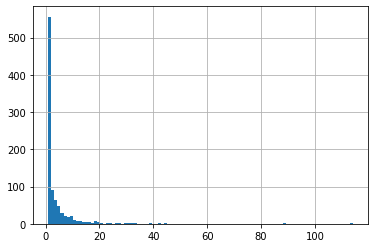

In [46]:
mean_ratings['count'].value_counts().hist(bins = 100) #최소 카운트를 뭘로할지 한번 해본다

### 문제 9. EDA & 전처리 - Popular 후보군 생성 결과 확인

In [47]:
mean_ratings[mean_ratings['count']>10]['mean'].sort_values(ascending=False) #최소 10명이상이 평가한것중 평균점수가 높은순서대로

movie_id
2905    4.608696
2019    4.560510
318     4.554558
858     4.524966
745     4.520548
          ...   
3573    1.461538
1323    1.372093
1739    1.361702
1495    1.318182
3574    1.058824
Name: mean, Length: 3233, dtype: float64

In [48]:
# 생성 결과를 popular_movie_list 변수에 할당
mean_ratings[mean_ratings['count']>10]['mean'].sort_values(ascending=False)[:20]
# ex.
# [4.608695652173913,
#  4.560509554140127,
#  4.554557700942973,
#  4.524966261808367,
#  4.52054794520548,
#  4.517106001121705,
#  4.510416666666667,
#  4.507936507936508,
#  4.491489361702127,
#  4.477724741447892]

movie_id
2905    4.608696
2019    4.560510
318     4.554558
858     4.524966
745     4.520548
50      4.517106
527     4.510417
1148    4.507937
922     4.491489
1198    4.477725
904     4.476190
1178    4.473913
260     4.453694
1212    4.452083
750     4.449890
3338    4.444444
720     4.426941
1207    4.425647
3435    4.415608
912     4.412822
Name: mean, dtype: float64

In [49]:
popular_movie_list = mean_ratings[mean_ratings['count']>10]['mean'].sort_values(ascending=False).index[:10].tolist()
popular_movie_list

[2905, 2019, 318, 858, 745, 50, 527, 1148, 922, 1198]

### 문제 10. EDA & 전처리 - 장르 & 연도 기준 Meta2Item 후보군 생성

In [50]:
# 장르 & 연도를 meta로 하는, meta별 상위 10개씩 popular list 추출
movie_df = pd.merge(mean_ratings, movie_df, on = 'movie_id')
#위에서 추출된 영화들의 메타데이터만 봅아 데이터프레임 뽑음
movie_df


,movie_id,mean,count,title,genre,decade,main_genre
0,1,4.146846,2077,Toy Story (1995),Animation|Children's|Comedy,1990,Animation
1,2,3.201141,701,Jumanji (1995),Adventure|Children's|Fantasy,1990,Adventure
2,3,3.016736,478,Grumpier Old Men (1995),Comedy|Romance,1990,Comedy
3,4,2.729412,170,Waiting to Exhale (1995),Comedy|Drama,1990,Comedy
4,5,3.006757,296,Father of the Bride Part II (1995),Comedy,1990,Comedy
...,...,...,...,...,...,...,...
3701,3948,3.635731,862,Meet the Parents (2000),Comedy,2000,Comedy
3702,3949,4.115132,304,Requiem for a Dream (2000),Drama,2000,Drama
3703,3950,3.666667,54,Tigerland (2000),Drama,2000,Drama
3704,3951,3.900000,40,Two Family House (2000),Drama,2000,Drama


In [51]:
# 장르&연도를 meta로 하여, meta별 상위 10개의 평점 높은 영화
def get_meta_popular_list(x, k):
  movie_id_list = x.sort_values(by=['mean'], ascending=False)['movie_id'].tolist()
  return movie_id_list[:k]

genre_popular = movie_df.groupby('main_genre').apply(lambda x: get_meta_popular_list(x, k=10))
year_popular = movie_df.groupby('decade').apply(lambda x: get_meta_popular_list(x, k=10))

In [52]:

genre_popular.head()


main_genre
Action        [2905, 2019, 858, 1198, 260, 1221, 2028, 2571,...
Adventure     [3172, 1204, 1262, 3470, 1254, 919, 1303, 1259...
Animation     [745, 1148, 720, 1223, 3429, 3114, 1, 741, 276...
Children's    [1097, 1028, 34, 262, 3396, 755, 531, 3397, 55...
Comedy        [1830, 3233, 3607, 3030, 3307, 3022, 1136, 341...
dtype: object

In [53]:
year_popular.head()

decade
1910                                   [3132, 2821, 2823]
1920    [3517, 3022, 3629, 2010, 3232, 1348, 3742, 330...
1930    [3382, 3307, 3134, 1260, 905, 919, 954, 950, 3...
1940    [3656, 1212, 3435, 912, 913, 923, 3089, 1284, ...
1950    [3172, 2019, 922, 904, 1178, 670, 668, 1250, 9...
dtype: object

### 문제 11. EDA & 전처리 - Meta 후보군 생성 결과 확인

In [54]:
genre_popular_dict =  genre_popular.to_dict()
genre_popular_dict

{'Action': [2905, 2019, 858, 1198, 260, 1221, 2028, 2571, 1197, 1233],
 'Adventure': [3172, 1204, 1262, 3470, 1254, 919, 1303, 1259, 29, 1931],
 'Animation': [745, 1148, 720, 1223, 3429, 3114, 1, 741, 2761, 1023],
 "Children's": [1097, 1028, 34, 262, 3396, 755, 531, 3397, 551, 1012],
 'Comedy': [1830, 3233, 3607, 3030, 3307, 3022, 1136, 3410, 2324, 1234],
 'Crime': [3656, 50, 3517, 3435, 1260, 296, 1213, 1945, 608, 1617],
 'Documentary': [3881, 787, 3338, 2930, 128, 1147, 3679, 363, 1189, 2859],
 'Drama': [3382, 989, 3245, 53, 2503, 318, 527, 578, 2480, 439],
 'Fantasy': [792, 2021],
 'Film-Noir': [922, 913, 1252, 1267, 1284, 2186, 930, 541, 2203, 2066],
 'Horror': [3280, 1219, 1258, 1348, 2648, 1997, 2664, 1340, 1333, 2644],
 'Musical': [899, 914, 1947, 2565, 3606, 1035, 3545, 900, 3675, 2971],
 'Mystery': [904, 1212, 903, 950, 906, 1086, 2206, 1625, 931, 2467],
 'Romance': [928, 28, 932, 2708, 2721, 1684, 803, 2833, 3368, 976],
 'Sci-Fi': [750, 1199, 2010, 1206, 1301, 2660, 1921, 365

In [55]:
year_popular_dict =  genre_popular.to_dict()
year_popular_dict

{'Action': [2905, 2019, 858, 1198, 260, 1221, 2028, 2571, 1197, 1233],
 'Adventure': [3172, 1204, 1262, 3470, 1254, 919, 1303, 1259, 29, 1931],
 'Animation': [745, 1148, 720, 1223, 3429, 3114, 1, 741, 2761, 1023],
 "Children's": [1097, 1028, 34, 262, 3396, 755, 531, 3397, 551, 1012],
 'Comedy': [1830, 3233, 3607, 3030, 3307, 3022, 1136, 3410, 2324, 1234],
 'Crime': [3656, 50, 3517, 3435, 1260, 296, 1213, 1945, 608, 1617],
 'Documentary': [3881, 787, 3338, 2930, 128, 1147, 3679, 363, 1189, 2859],
 'Drama': [3382, 989, 3245, 53, 2503, 318, 527, 578, 2480, 439],
 'Fantasy': [792, 2021],
 'Film-Noir': [922, 913, 1252, 1267, 1284, 2186, 930, 541, 2203, 2066],
 'Horror': [3280, 1219, 1258, 1348, 2648, 1997, 2664, 1340, 1333, 2644],
 'Musical': [899, 914, 1947, 2565, 3606, 1035, 3545, 900, 3675, 2971],
 'Mystery': [904, 1212, 903, 950, 906, 1086, 2206, 1625, 931, 2467],
 'Romance': [928, 28, 932, 2708, 2721, 1684, 803, 2833, 3368, 976],
 'Sci-Fi': [750, 1199, 2010, 1206, 1301, 2660, 1921, 365

In [56]:
# 위 결과 확인
# ex.
# 연도별 popular list - {'1910': [3132, 2821, 2823], '1920': [3517, 3022, 3629, 2010], ....}

## Step 3. Point-wise 데이터셋 생성

#### Ranking Model

    [랭킹 모델의 형태와 역할]
    1. Binary Classification을 학습하는 Regressor가 가장 대표적인 예
    2. y=1은 User가 Item을 시청(혹은 구매 등)한 경우 -> **Ground Truth**
    3. f(x_ui) = X_u + X_i + b -> **X_u는 User의 여러가지 정보를 벡터로 나타낸 것, 그리고 X_i는 아이템의 여러가지 정보를 벡터로 나타낸 것**
    4. NDCG, AUC, Top@Precision... 등을 기준으로 모델을 학습 (랭킹 학습 방식인 Point-wise, Pair-wise 등을 기준으로 각각 다름)

![point-wise](https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/images/point-wise.png)

### 문제 12. EDA & 전처리 - 특정 시간 기준 데이터셋 분리

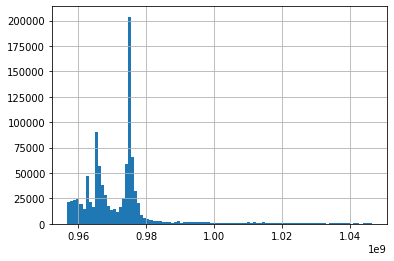

In [57]:
# 데이터셋을 8:2로 나눌 수 있는 시간을 기준으로 데이터셋을 train,test로 분리
rating_df['time'].hist(bins = 100)

In [58]:
rating_df['time'].quantile( q = 0.8, interpolation = 'nearest')
#0.8로 나누는 유닉스시간을 알아봄

975768738

In [59]:
train_df = rating_df[rating_df['time'] < 975768738]
test_df = rating_df[rating_df['time'] >= 975768738] #위의 시간을 기준으로하면 8대2로 데이터 분리 가능

### 문제 13. User Profiling - 유저 속성 EDA (gender, age, occupation, zipcode)

##### 1) Gender

In [60]:
# gender 피처 탐색
user_df.head() #user_df의 내용보기

,user_id,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


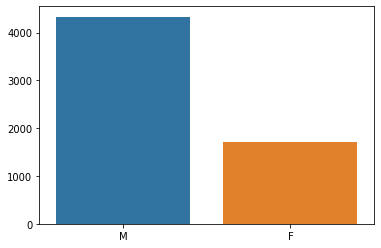

In [61]:
gender = user_df['gender'].value_counts()
sns.barplot(gender.index, gender.values)

#### 2) Age

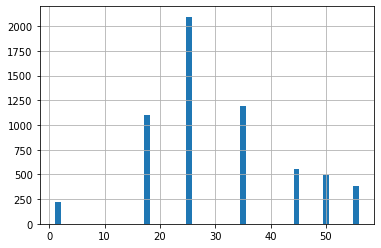

In [62]:
# age 피처 탐색
user_df['age'].hist(bins = 'auto') #타일이 그닥 여러개는 아님(빽빽하지 않음) -> value_counts로 본다

In [63]:
user_df['age'].value_counts() #나이가 뭉쳐서 있음. 1은 잘못된거 같음

25    2096
35    1193
18    1103
45     550
50     496
56     380
1      222
Name: age, dtype: int64

In [64]:
# age 피처 bucketize
def age_bucketize(age):
    if age == 1:
        return 'outlier'
    else:
        return str(age)[0] + "0" #10대, 20대, .. 이런식으로 만들어줌


user_df['age_bucket'] = user_df['age'].apply(lambda x: age_bucketize(x))
user_df['age_bucket'].value_counts()

20         2096
30         1193
10         1103
50          876
40          550
outlier     222
Name: age_bucket, dtype: int64

#### 3) Occupation

In [65]:
# occupation 피처 탐색
user_df['occupation'].value_counts()

4     759
0     711
7     679
1     528
17    502
12    388
14    302
20    281
2     267
16    241
6     236
10    195
3     173
15    144
13    142
11    129
5     112
9      92
19     72
18     70
8      17
Name: occupation, dtype: int64

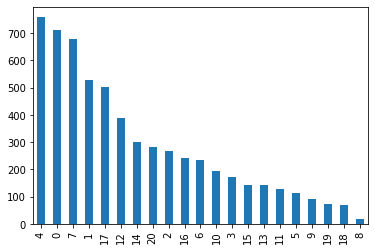

In [66]:
user_df['occupation'].value_counts().plot(kind = 'bar') #꽤 고루게 분포 -> 학습에 바로 쓸 수있어 보임 (내용을 파악하는건 당장 중요하진 않음)

#### 4) Zipcode

In [67]:
# zipcode 피처 탐색
user_df['zipcode'].value_counts()

48104    19
22903    18
55104    17
94110    17
10025    16
         ..
11743     1
19026     1
97701     1
92100     1
73120     1
Name: zipcode, Length: 3439, dtype: int64

In [68]:
# user_df['zipcode'].value_counts().plot(kind = 'bar')
#여러개로 퍼져있음 -> 그닥 안중요할수도? (지역 특색(날씨등)을 고려할수도있겠지만 너무 작은 데이터라 그렇게까지 안봐도 될듯), uniform distribution이라 쓰기도 어려움

### 문제 14. User Profiling - 유저 속성별 피쳐맵 생성

In [69]:
user_df.head() #gender, age_bucket, occpution 정도만 써도 될듯

,user_id,gender,age,occupation,zipcode,age_bucket
0,1,F,1,10,48067,outlier
1,2,M,56,16,70072,50
2,3,M,25,15,55117,20
3,4,M,45,7,02460,40
4,5,M,25,20,55455,20


#### 1) Gender

In [70]:
# gender 피처맵 생성
gender_list = user_df['gender'].unique()
gender_index = {}
for idx, gender in enumerate(gender_list): #index를 자체를 딕셔너리로 해주기위해 enumerate를 함 -> 각 카테고리별로 숫자 부여
  gender_index[gender] = idx + 1

# index 자체를 표현한다는 의미 -> 카테고리별로 숫자값을 줌 ex) {'F': 1, 'M': 2}

In [71]:
gender_index

{'F': 1, 'M': 2}

#### 2) Age

In [72]:
# age 피처맵 생성

age_list = user_df['age_bucket'].unique()
age_index = {}
for idx, age in enumerate(age_list): #index를 자체를 딕셔너리로 해주기위해 enumerate를 함 
  age_index[age] = idx + 1


# ex.
# {'10': 6, '20': 3, '30': 5, '40': 4, '50': 2, 'outlier': 1}

In [73]:
age_index

{'10': 6, '20': 3, '30': 5, '40': 4, '50': 2, 'outlier': 1}

#### 3) Occupation

In [74]:
# occupation 피처맵 생성

occupation_list = user_df['occupation'].unique()
occupation_index = {}
for idx, occupation in enumerate(occupation_list): #index를 자체를 딕셔너리로 해주기위해 enumerate를 함
  occupation_index[occupation] = idx + 1

# ex.
# {0: 10,
#  1: 7,
#  2: 17,
#  3: 11,
#  4: 13,
#  ...}

In [75]:
occupation_index

{0: 10,
 1: 7,
 2: 17,
 3: 11,
 4: 13,
 5: 19,
 6: 21,
 7: 4,
 8: 15,
 9: 6,
 10: 1,
 11: 14,
 12: 8,
 13: 20,
 14: 12,
 15: 3,
 16: 2,
 17: 9,
 18: 18,
 19: 16,
 20: 5}

### 문제 15. Item Profiling - 영화 속성별 피쳐맵 생성 (장르, 년도)

In [76]:
movie_df #이 데이터로 함

,movie_id,mean,count,title,genre,decade,main_genre
0,1,4.146846,2077,Toy Story (1995),Animation|Children's|Comedy,1990,Animation
1,2,3.201141,701,Jumanji (1995),Adventure|Children's|Fantasy,1990,Adventure
2,3,3.016736,478,Grumpier Old Men (1995),Comedy|Romance,1990,Comedy
3,4,2.729412,170,Waiting to Exhale (1995),Comedy|Drama,1990,Comedy
4,5,3.006757,296,Father of the Bride Part II (1995),Comedy,1990,Comedy
...,...,...,...,...,...,...,...
3701,3948,3.635731,862,Meet the Parents (2000),Comedy,2000,Comedy
3702,3949,4.115132,304,Requiem for a Dream (2000),Drama,2000,Drama
3703,3950,3.666667,54,Tigerland (2000),Drama,2000,Drama
3704,3951,3.900000,40,Two Family House (2000),Drama,2000,Drama


#### 1) Genre

In [77]:
# genre 피처맵 생성

genre_list = movie_df['main_genre'].unique()
genre_index = {}
for idx, genre in enumerate(genre_list):  # 각 카테고리별로 숫자 부여
  genre_index[genre] = idx + 1

# ex.
# {'Action': 4,
#  'Adventure': 2,
#  'Animation': 1,
#  "Children's": 9,
#  'Comedy': 3,
#  'Crime': 7,
#  'Documentary': 10,
#  'Drama': 5,
#  'Fantasy': 17,
#  'Film-Noir': 15,
#  'Horror': 12,
#  'Musical': 18,
#  'Mystery': 14,
#  'Romance': 8,
#  'Sci-Fi': 11,
#  'Thriller': 6,
#  'War': 16,
#  'Western': 13}

In [78]:
genre_list

array(['Animation', 'Adventure', 'Comedy', 'Action', 'Drama', 'Thriller',
       'Crime', 'Romance', "Children's", 'Documentary', 'Sci-Fi',
       'Horror', 'Western', 'Mystery', 'Film-Noir', 'War', 'Fantasy',
       'Musical'], dtype=object)

#### 2) Year

In [79]:
# year 피처맵 생성
year_list = movie_df['decade'].unique()
year_index = {}
for idx, year in enumerate(year_list):
  year_index[year] = idx + 1

In [80]:
year_list

array(['1990', '1970', '1980', '1960', '1930', '1940', '1950', '1920',
       '1910', '2000'], dtype=object)

### 문제 16. Context Profiling - 특정 시간 기준 유저 행동 EDA (시청한 영화 정보, 시청한 영화 점수 분포)

In [81]:
# 위에서 만든 feature map이 시간을 잘 고려한것인지 확인해본다
train_df.head()

,user_id,movie_id,rating,time
94507,635,1251,4,975768620
94513,635,3948,4,975768294
94518,635,1270,4,975768106
94519,635,1279,5,975768520
94522,635,1286,4,975768106


In [82]:
train_df = pd.merge(train_df, movie_df, on='movie_id')
train_df = pd.merge(train_df, user_df, on='user_id')
train_df.head() #train_df에 유저와 item이 병합된 형태로 만들어짐

,user_id,movie_id,rating,time,mean,count,title,genre,decade,main_genre,gender,age,occupation,zipcode,age_bucket
0,635,1251,4,975768620,4.105263,228,8 1/2 (1963),Drama,1960,Drama,M,56,17,33785,50
1,635,3948,4,975768294,3.635731,862,Meet the Parents (2000),Comedy,2000,Comedy,M,56,17,33785,50
2,635,1270,4,975768106,3.990321,2583,Back to the Future (1985),Comedy|Sci-Fi,1980,Comedy,M,56,17,33785,50
3,635,1279,5,975768520,3.747423,194,Night on Earth (1991),Comedy|Drama,1990,Comedy,M,56,17,33785,50
4,635,1286,4,975768106,3.585965,285,Somewhere in Time (1980),Drama|Romance,1980,Drama,M,56,17,33785,50


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


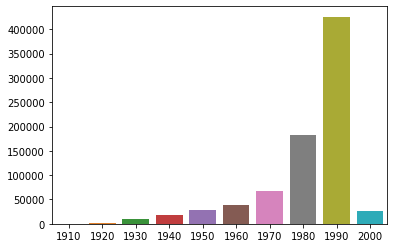

In [83]:
# 위에서 만든 시청한 영화 정보 탐색(movie_df)과 train_df의 분포가 얼마나 차이나는지 한번 봐본다 - > 다르면 feature 맵을 다르게 해줘야한다
released_year_area = train_df['decade'].value_counts().sort_index()
sns.barplot(released_year_area.index, released_year_area.values) #큰차이는 없어보인다

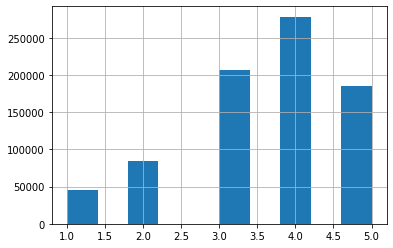

In [84]:
train_df['rating'].hist()
#이것도 movie_df로 햇을때 와 비슷
#위에서 했던 방법으로 학습을 준비시켜도 될듯하다

In [85]:
# 시간 기준으로 분리한 데이터셋 EDA
train_df['main_genre'].value_counts()

Comedy         219077
Action         210721
Drama          163949
Horror          36100
Adventure       35315
Crime           30569
Animation       29121
Children's      17088
Thriller        13974
Sci-Fi           9144
Mystery          8229
Film-Noir        7742
Musical          5600
Documentary      5283
Western          4654
Romance          2122
War               809
Fantasy           667
Name: main_genre, dtype: int64

In [86]:
train_df = train_df

### 문제 17. Feature Mapping - Profiling 피처맵 맵핑

In [87]:
# profile 완료된 경과로 피처맵 맵핑
train_df = train_df[['user_id', 'movie_id', 'rating', 'decade', 'main_genre', 'gender', 'occupation', 'age_bucket']]
train_df['decade'] = train_df['decade'].apply(lambda x: year_index[x])
train_df['main_genre'] = train_df['main_genre'].apply(lambda x: genre_index[x])
train_df['gender'] = train_df['gender'].apply(lambda x: gender_index[x])
train_df['occupation'] = train_df['occupation'].apply(lambda x: occupation_index[x])
train_df['age_bucket'] = train_df['age_bucket'].apply(lambda x: age_index[x])
# ex.
# 	user_id	movie_id	rating	released_year_area	main_genre	gender	occupation	age_bucket
# 0	635	1251	4	4	5	2	9	2
# 1	635	3948	4	10	3	2	9	2
# 2	635	1270	4	3	3	2	9	2
# 3	635	1279	5	1	3	2	9	2
# 4	635	1286	4	3	5	2	9	2

In [88]:
train_df

,user_id,movie_id,rating,decade,main_genre,gender,occupation,age_bucket
0,635,1251,4,4,5,2,9,2
1,635,3948,4,10,3,2,9,2
2,635,1270,4,3,3,2,9,2
3,635,1279,5,1,3,2,9,2
4,635,1286,4,3,5,2,9,2
...,...,...,...,...,...,...,...,...
800159,4528,912,4,6,5,2,12,3
800160,4528,2395,4,1,3,2,12,3
800161,4528,2599,5,1,3,2,12,3
800162,3326,912,4,6,5,2,4,4


In [89]:
test_df = pd.merge(test_df, movie_df, on='movie_id')
test_df = pd.merge(test_df, user_df, on='user_id')

test_df = test_df[['user_id', 'movie_id', 'rating', 'decade', 'main_genre', 'gender', 'occupation', 'age_bucket']]
test_df['decade'] = test_df['decade'].apply(lambda x: year_index[x])
test_df['main_genre'] = test_df['main_genre'].apply(lambda x: genre_index[x])
test_df['gender'] = test_df['gender'].apply(lambda x: gender_index[x])
test_df['occupation'] = test_df['occupation'].apply(lambda x: occupation_index[x])
test_df['age_bucket'] = test_df['age_bucket'].apply(lambda x: age_index[x])

test_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,user_id,movie_id,rating,decade,main_genre,gender,occupation,age_bucket
0,1,1193,5,2,5,1,1,1
1,1,661,3,1,1,1,1,1
2,1,914,3,4,18,1,1,1
3,1,3408,4,10,5,1,1,1
4,1,2355,5,1,1,1,1,1
...,...,...,...,...,...,...,...,...
200040,3453,3158,2,1,5,2,4,5
200041,3453,2293,3,1,5,2,4,5
200042,3453,2275,1,1,4,2,4,5
200043,3072,1455,4,1,3,2,7,2


### 문제 18. Binary Transformation - 평가 점수 기준으로 (0,1) 변환

In [ ]:
# regression 데이터 셋을 만들듯 point wise 데이터 셋을 만듬
# => y값 설정이 중요 => 랭킹모델 기준점에 따라 y값 설정이 다름 ( ex) 시청 여부에 따라 0 또는 1 로 준다)
# => 여기서는 본 기록 또는 rating에 따라 나눌수도 있을것 같다

In [90]:
# rating이 4점 이상인 경우 1, 3점 이하인 경우 0으로 변환 (높게 평가: 1 , 낮게평가: 0)
train_df['y'] = train_df['rating'].apply(lambda x: 1 if x >= 4 else 0)
train_df.sample(10).head()

#이제 Regression을 수행가능
#근데 우리의 목적은 회귀를 하는게 아닌 Factorization Machine 알고리즘을 통해 Raking machine 이라는 알고리즘을 만들것임
#그래도 Input과 output을 넣고 빼는건 로지스틱 회귀랑 다를게 없다 -> 알고리즘만 다른 것

,user_id,movie_id,rating,decade,main_genre,gender,occupation,age_bucket,y
725582,2347,3555,4,10,4,2,7,5,1
710453,5792,2693,5,1,10,2,9,3,1
466794,5011,32,4,1,5,2,13,6,1
258965,2737,1580,3,1,4,2,11,3,0
349987,3759,333,5,1,3,2,21,5,1


### 문제 19. Feature Vector 생성 - libsvm 포맷의 데이터셋 생성


#### Sparse Vector in Linear Model

    [libsvm]
    1. sparse vector를 표현하기에 적합
    2. 용량을 크게 차지 않하고 sparse vector 표현 가능

    [Sparse Vector]
    1. 0, 1로 값을 표현하는 벡터가 매우 희소한 상황 (대부분이 0임)
    2. 아래 그림에서 3002개의 벡터 중, 1이 등장하는 벡터는 단 두개
    3. Linear Model에서 Sparse 하다는 것은 이러한 상황을 의미
    4. OneHot encoding 형식

![sparse](https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/images/sparse.png)

----

    [Linear Model]
    1. 입력 특성에 대한 선형 함수를 만들어 예측을 수행하는 모델
    2. y = a1x1 + a2x2... 같은 방정식이라고 생각할 수 있음
    3. 일반적인 랭킹 모델은 Linear Model로 마지막 추론을 하게 되어있음
    4. x1, x2...가 바로 Sparse Vector를 의미함

----

    [libsvm 포맷]
    1. "index":"value" 형태로 sparse vector를 표현하는 형태
    2. 위 그림을 표현하면, "1:1 3001:1" 이 됨. (one hot encoding의 고지식함을 좀 개선 해준 느낌)

In [93]:
# libsvm 포맷의 데이터셋 생성
col_len_dict = {'user_id': len(train_df['user_id'].unique()),
                'movie_id': len(train_df['movie_id'].unique()),
                'decade': len(train_df['decade'].unique()), 
                'main_genre': len(train_df['main_genre'].unique()), 
                'gender': len(train_df['gender'].unique()), 
                'occupation': len(train_df['occupation'].unique()),
                'age_bucket': len(train_df['age_bucket'].unique())} #카테고리별로 무수히 긴 벡터에 0,1 을 때려 넣는게 아닌
                # 딕셔너리를 통해 각 카테고리별 인덱스를 넣어놓는 형식
col_accum_index_dict = {} #위에있는 각 점수를 축척한 값. -> 개별 sparse 벡터가 딕셔너리 형태 좌표값으로 있는건데.
#그걸 모두 뭉쳤을때 하나의 벡터로 표현하기위해 각 sparse vector가 어느 위치에 있는지 알려주기위해 값들을 누적해서 표현해줌 
cumulative = 0
for key, value in col_len_dict.items():
    col_accum_index_dict[key] = cumulative
    cumulative = cumulative + value

In [94]:
col_len_dict

{'age_bucket': 6,
 'decade': 10,
 'gender': 2,
 'main_genre': 18,
 'movie_id': 3662,
 'occupation': 21,
 'user_id': 5400}

In [95]:
col_accum_index_dict

{'age_bucket': 9113,
 'decade': 9062,
 'gender': 9090,
 'main_genre': 9072,
 'movie_id': 5400,
 'occupation': 9092,
 'user_id': 0}

In [96]:
# ex. 1 634:1 6650:1 9065:1 9076:1 9091:1 9100:1 9114:1

for idx, row in train_df.iterrows(): #libsvm 표현했을때 특정유저의 특정movie에 대한 특정 feacture을 sparse vector로 만들어줌
  vec = []
  label = row['y']
  vec.append(str(label))
  row = row.drop(labels=['rating'])
  row = row.drop(labels=['y'])
  for key, value in row.items():
    col_idx = col_accum_index_dict[key] + value - 1 #libsvm 표현했을때 특정유저의 특정movie에 대한 특정 feacture의 값에 대한 index. Value는 1이다
    vec.append(str(col_idx) + ":" + str(1))
  print("%s\n" % " ".join(vec))
  break 

1 634:1 6650:1 9065:1 9076:1 9091:1 9100:1 9114:1



In [97]:
train_df

,user_id,movie_id,rating,decade,main_genre,gender,occupation,age_bucket,y
0,635,1251,4,4,5,2,9,2,1
1,635,3948,4,10,3,2,9,2,1
2,635,1270,4,3,3,2,9,2,1
3,635,1279,5,1,3,2,9,2,1
4,635,1286,4,3,5,2,9,2,1
...,...,...,...,...,...,...,...,...,...
800159,4528,912,4,6,5,2,12,3,1
800160,4528,2395,4,1,3,2,12,3,1
800161,4528,2599,5,1,3,2,12,3,1
800162,3326,912,4,6,5,2,4,4,1


## Step 4. 추천 랭킹 모델링 (Factorization Machine)

#### Factorization Machine

![equation](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbRP7gn%2FbtqDw3LQxDB%2FXmWK8heUckUWpHx379UCM1%2Fimg.png)

    
    위에 식 : Regression + MF 의 꼴
    [랭킹 모델의 형태와 역할]
    1. Linear Regression, SVM처럼 동작하는 General predictor
    2. 변수 간의 모든 pair-wise interaction을 계산하는 알고리즘
    3. General predictor의 장점 + MF 알고리즘이 가지는 의미 단위 해석(latent factor)의 장점
    4. sparse한 데이터셋을 가지고 있을 때 적합

### 문제 20. 학습 데이터 생성 - 특정 시간 기준 Train/Test 데이터셋 생성

In [98]:
!pip install xlearn #파이썬 기반 C++라이브러리라 쓰기가 쉽지는 않다

     |████████████████████████████████| 4.9 MB 4.0 MB/s 
  Created wheel for xlearn: filename=xlearn-0.40a1-py3-none-any.whl size=229989 sha256=d9c924e5e9e66919d1b4442341f86a499fbd14811a50d645457b1959d505a823
  Stored in directory: /root/.cache/pip/wheels/1e/6d/eb/256faaf8142a9363431e2dc3f6a3d1c9080f526a1e5475049d
Successfully built xlearn


In [ ]:
txt_file = open('train.txt', 'w')
for idx, row in train_df.iterrows():
  vec = []
  label = row['y']
  vec.append(str(label))
  row = row.drop(labels=['rating'])
  row = row.drop(labels=['y'])
  for key, value in row.items():
    col_idx = col_accum_index_dict[key] + value - 1
    vec.append(str(col_idx) + ":" + str(1))
  txt_file.write("%s\n" % " ".join(vec))
txt_file.close()

In [ ]:
txt_file = open('test.txt', 'w')
for idx, row in test_df.iterrows():
  vec = []
  label = row['y']
  vec.append(str(label))
  row = row.drop(labels=['rating'])
  row = row.drop(labels=['y'])
  for key, value in row.items():
    col_idx = col_accum_index_dict[key] + value - 1
    vec.append(str(col_idx) + ":" + str(1))
  txt_file.write("%s\n" % " ".join(vec))
txt_file.close()

### 문제 21. 모델링 - FM Binary Classification 모델 학습

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score


class FactorizationMachine():
    """
    This Class is implementation of this paper : https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf
    Just a example of FM Algorithm, not for production.
    -----
    Only simple methods are available.
    e.g 1 : batch training, adagrad optimizer, parallel training are not supported.
    e.g 2 : simple optimizer Stochastic Gradient Descent with L2 Regularization.
    e.g 3 : using titanic dataset on local memory.
    """
    def __init__(self, k, lr, l2_reg, l2_lambda, epoch, early_stop_window, train_data, valid_data):
        """
        :param k: number of latent vector
        :param lr: learning rate
        :param l2_reg: bool parameter for L2 regularization
        :param l2_lambda: lambda of L2 regularization
        :param epoch: training epoch
        :param train_data: path of train data
        :param valid_data: path of valid data
        """
        self._k = k
        self._lr = lr
        self._l2_reg = l2_reg
        self._l2_lambda = l2_lambda
        self._epoch = epoch
        self._early_stop_window = early_stop_window
        self._train_file_path = train_data
        self._valid_file_path = valid_data
        self._valid_loss_list = []

    def _load_dataset(self):
        """
        1. load dataset to memory from train/valid path
        2. find max index in dataset for w's vector size
        """
        # load data
        train_file = open(self._train_file_path, 'r')
        valid_file = open(self._valid_file_path, 'r')
        self._train_data = train_file.read().split('\n')
        self._valid_data = valid_file.read().split('\n')
        train_file.close()
        valid_file.close()

        # find max index
        self.feature_max_index = 0
        print("Start to init FM vectors.")
        for row in self._train_data:
            for element in row.split(" ")[1:]:
                index = int(element.split(":")[0])
                if self.feature_max_index < index:
                    self.feature_max_index = index

        for row in self._valid_data:
            for element in row.split(" ")[1:]:
                index = int(element.split(":")[0])
                if self.feature_max_index < index:
                    self.feature_max_index = index

        # init FM vectors
        self._init_vectors()
        print("Finish init FM vectors.")

    def _init_vectors(self):
        """
        1. initialize FM vectors
        2. Conduct naive transformation libsvm format txt data to numpy training sample.
        """
        self.w = np.random.randn(self.feature_max_index+1)
        self.v = np.random.randn(self.feature_max_index+1, self._k)
        self.train_x_data = []
        self.train_y_data = np.zeros((len(self._train_data)-1))
        self.valid_x_data = []
        self.valid_y_data = np.zeros((len(self._valid_data)-1))

        # make numpy dataset
        for n, row in enumerate(self._train_data):
            element = row.split(" ")
            if len(element) > 1:
              self.train_y_data[n] = int(element[0])
              self.train_x_data.append([np.array([int(pair.split(":")[0]) for pair in element[1:]]),
                                        np.array([int(pair.split(":")[1]) for pair in element[1:]])])

        for n, row in enumerate(self._valid_data):
            element = row.split(" ")
            if len(element) > 1:
              self.valid_y_data[n] = int(element[0])
              self.valid_x_data.append([np.array([int(pair.split(":")[0]) for pair in element[1:]]),
                                        np.array([int(pair.split(":")[1]) for pair in element[1:]])])

    def train(self):
        """
        Train FM model by Gradient Descent with L2 regularization
        """
        self._load_dataset()
        for epoch_num in range(1, self._epoch):
            train_y_hat = self.predict(data=self.train_x_data)
            valid_y_hat = self.predict(data=self.valid_x_data)
            train_loss = self._get_loss(y_data=self.train_y_data, y_hat=train_y_hat)
            valid_loss = self._get_loss(y_data=self.valid_y_data, y_hat=valid_y_hat)
            train_auc = roc_auc_score(self.train_y_data, train_y_hat)
            valid_auc = roc_auc_score(self.valid_y_data, valid_y_hat)
            self._print_learning_info(epoch=epoch_num, train_loss=train_loss, valid_loss=valid_loss,
                                      train_auc=train_auc, valid_auc=valid_auc)
            if self._check_early_stop(valid_loss=valid_loss):
                print("Early stop at epoch:", epoch_num)
                return 0

            self._stochastic_gradient_descent(self.train_x_data, self.train_y_data)

    def predict(self, data):
        """
        Implementation of FM model's equation on O(kmd)
        -----
        Numpy array shape : (n, [index of md], [value of md])
        md : none-zero feature
        """
        num_data = len(data)
        scores = np.zeros(num_data)
        for n in range(num_data):
            feat_idx = data[n][0]
            val = data[n][1]

            # linear feature score
            linear_feature_score = np.sum(self.w[feat_idx] * val)

            # factorized feature score
            vx = self.v[feat_idx] * (val.reshape(-1, 1))
            cross_sum = np.sum(vx, axis=0)
            square_sum = np.sum(vx * vx, axis=0)
            cross_feature_score = 0.5 * np.sum(np.square(cross_sum) - square_sum)

            # Model's equation
            scores[n] = linear_feature_score + cross_feature_score

        # Sigmoid transformation for binary classification
        scores = 1.0 / (1.0 + np.exp(-scores))
        return scores

    def _get_loss(self, y_data, y_hat):
        """
        Calculate loss with L2 regularization (two type of coeficient - w,v)
        """
        l2_norm = 0
        if self._l2_reg:
            w_norm = np.sqrt(np.sum(np.square(self.w)))
            v_norm = np.sqrt(np.sum(np.square(self.v)))
            l2_norm = self._l2_lambda * (w_norm + v_norm)
        return -1 * np.sum( (y_data * np.log(y_hat)) + ((1 - y_data) * np.log(1 - y_hat)) ) + l2_norm

    def _check_early_stop(self, valid_loss):
        self._valid_loss_list.append(valid_loss)
        if len(self._valid_loss_list) > 5:
            prev_loss = self._valid_loss_list[len(self._valid_loss_list) - self._early_stop_window]
            curr_loss = valid_loss
            if prev_loss < curr_loss:
                return True
        return False

    def _print_learning_info(self, epoch, train_loss, valid_loss, train_auc, valid_auc):
        print("epoch:", epoch, "||", "train_loss:", train_loss, "||", "valid_loss:", valid_loss,
              "||", "Train AUC:", train_auc, "||", "Test AUC:", valid_auc)


    def _stochastic_gradient_descent(self, x_data, y_data):
        """
        Update each coefs (w, v) by Gradient Descent
        """
        for data, y in zip(x_data, y_data):
            feat_idx = data[0]
            val = data[1]
            vx = self.v[feat_idx] * (val.reshape(-1, 1))

            # linear feature score
            linear_feature_score = np.sum(self.w[feat_idx] * val)

            # factorized feature score
            vx = self.v[feat_idx] * (val.reshape(-1, 1))
            cross_sum = np.sum(vx, axis=0)
            square_sum = np.sum(vx * vx, axis=0)
            cross_feature_score = 0.5 * np.sum(np.square(cross_sum) - square_sum)

            # Model's equation
            score = linear_feature_score + cross_feature_score
            y_hat = 1.0 / (1.0 + np.exp(-score))
            cost = y_hat - y

            if self._l2_reg:
                self.w[feat_idx] = self.w[feat_idx] - cost * self._lr * (val + self._l2_lambda * self.w[feat_idx])
                self.v[feat_idx] = self.v[feat_idx] - cost * self._lr * ((sum(vx) * (val.reshape(-1, 1)) - (vx * (val.reshape(-1, 1)))) + self._l2_lambda * self.v[feat_idx])
            else:
                self.w[feat_idx] = self.w[feat_idx] - cost * self._lr * val
                self.v[feat_idx] = self.v[feat_idx] - cost * self._lr * (sum(vx) * (val.reshape(-1, 1)) - (vx * (val.reshape(-1, 1))))

### 문제 22. 모델링 - AUC 평가

In [ ]:
fm = FactorizationMachine(k=4,#MF에서 Latent Factor의 dimension
                          lr=0.005, #Learning rating
                          l2_reg=True, #그 외 정규화
                          l2_lambda=0.0002, #그 외 정규화
                          epoch=30,
                          early_stop_window=3, #3번째 반복부터 큰차이 없으면 학습 중단
                          train_data='./train.txt',
                          valid_data='./test.txt')
fm.train()

Start to init FM vectors.
Finish init FM vectors.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:152: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in multiply


epoch: 1 || train_loss: nan || valid_loss: nan || Train AUC: 0.4921103729117869 || Test AUC: 0.49304915298621127
epoch: 2 || train_loss: 736900.2836016961 || valid_loss: 198644.74687446197 || Train AUC: 0.5800798753509125 || Test AUC: 0.5619787034050658
epoch: 3 || train_loss: 651009.9312976537 || valid_loss: 180090.75890737606 || Train AUC: 0.6170377247586235 || Test AUC: 0.5872701632247662
epoch: 4 || train_loss: 605023.7906217531 || valid_loss: 169998.84888488898 || Train AUC: 0.6425698141531598 || Test AUC: 0.6041856323230529
epoch: 5 || train_loss: 576017.5491097918 || valid_loss: 163575.5639834436 || Train AUC: 0.6614054044251164 || Test AUC: 0.6166846867487699
epoch: 6 || train_loss: 555887.8108497746 || valid_loss: 159121.3592374289 || Train AUC: 0.6759621226758684 || Test AUC: 0.6264261366402801
epoch: 7 || train_loss: 541028.4093140943 || valid_loss: 155872.33083542256 || Train AUC: 0.6875697318401519 || Test AUC: 0.634224237309259
epoch: 8 || train_loss: 529556.0962632183 ||

## Step 5. 모의 추천 시스템 구축

### 문제 23. 추천 결과 평가 - 특정 시간 기준 유저별 시청 목록 추출 (Train/Test과 동일 기준)

In [ ]:
# train 데이터셋에서 유저 시청 목록 추출

### 문제 24. 추천 결과 평가 - Train 데이터 기반 유저별 추천 후보군 생성

#### 1) 최근 시청한 3개 영화의 연관 영화 목록 추출

In [ ]:
# train 데이터셋으로만 m2v 모델 학습

In [ ]:
model = Word2Vec(movie2vec_dataset,
                 size=100,
                 window=6,  # 주변 word의 윈도우
                 sg=1,  # skip-gram OR cbow
                 hs=0,  # hierarchical softmax OR negative sampling
                 negative=20,  # negative sampling 파라미터
                 min_count=1,  # word의 등장 최소 횟수
                 iter=20)

In [ ]:
# 유저별 최근 시청한 3개 영화 추출
recent_user_watch_list = rating_df[rating_df['time'] < 975768738].groupby('user_id')[['movie_id', 'time']].apply(lambda x : get_recent_movie_list_sort_by_time(x, 3))

In [ ]:
# 영화별 연관 영화 (item2item) k개씩 추출

#### 2) 평점 기반 인기 영화

In [ ]:
# 평점 높은 상위 10개의 영화 추출

#### 3) 장르, 연도별 인기 영화

In [ ]:
# 장르&연도를 meta로 하여, meta별 상위 10개의 평점 높은 영화 리스트 추출

#### 4) 4개 추천 후보군 병합

In [ ]:
# 위에서 추출한 후보군들을 하나로 병합

##### 유저별 선호 장르/연도 파악

In [ ]:
# 1. 유저별 시청 히스토리를 기준으로 선호하는 장르/연도 지정
# 2. 선호하는 장르/연도의 인기 리스트 추출

##### 최종 병합

### 문제 25. 추천 결과 평가 - 랭킹 모델로 추천 후보군 K개 정렬

#### predict 가능한 포맷으로 변경
- ex) [[array([31, 55, 66, 77]), array([1, 1, 1, 1])]]

#### 후보군 정렬

In [ ]:
# 유저별 추천 후보군 재정렬
# ex. 
# {635: {1664: 0.49089334810703084, 3498: 0.7017178066091346, 2444: 0.3960630484760756...}, ...}
# -> {userid: {movieid: score...}...}

In [ ]:
str(user_recommendation_dict)[:2000]

'{635: {1664: 0.49089334810703084, 3498: 0.7017178066091346, 2444: 0.3960630484760756, 3152: 0.9267421332219103, 527: 0.906818420614163, 787: 0.8598210292115226, 2964: 0.49588669638145944, 922: 0.982938255727678, 1178: 0.9484776307851908, 1041: 0.8669462244704258, 537: 0.549539598898913, 1701: 0.8241026949792277, 1830: 0.16538777379886402, 372: 0.40789551375524885, 50: 0.9608472119143907, 2908: 0.8413125456347317, 53: 0.40820096414145074, 3382: 0.9968718349209549, 318: 0.912371092519536, 1471: 0.8704239191580381, 3006: 0.8130977243189997, 3522: 0.781827773625932, 2503: 0.6881686870074593, 2610: 0.9471364810657155, 1955: 0.7705156756575101, 2905: 0.8373731467801648, 858: 0.9526282013504191, 989: 0.1534201482163519, 371: 0.5308118956903058, 2019: 0.9851106898334485, 3201: 0.7831165743484206, 745: 0.9605919071180541, 2930: 0.9943506643249671, 1476: 0.6154292429949801, 1148: 0.9551935409057166, 3163: 0.7549520403458307}, 636: {1664: 0.9969645379579196, 2977: 0.39311269548383027, 466: 0.356

## Step 6. 추천 결과 평가

### 문제 26. 추천 결과 평가 - 추천 후보군과 Test 데이터간의 MAP@K 계산

In [ ]:
# 4점 이상을 준 test 시청 리스트 추출하여 MAP 계산

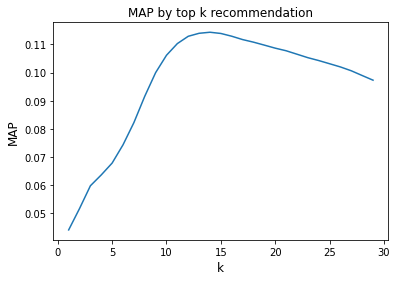

In [ ]:
# 아래 그래프처럼 map@k 시각화